In [1]:
%load_ext autoreload
%autoreload 2
#Basic package
import math
import random
import time
import numpy as np
import pandas as pd
import xlwt
#ML
from scipy.spatial.distance import cdist
from scipy.cluster.vq import vq
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans  
from sklearn.datasets import make_blobs
from sklearn import cluster, datasets
#Plot
from matplotlib.pyplot import *
from pylab import *
import matplotlib.pyplot as plt
#functions for the framework
from util import *
from related_SM_algorithm import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
##################
data = 'a2.csv'
##################

(5250, 2)
(35, 2) <class 'numpy.ndarray'>


Text(0.5, 1.0, 'a2')

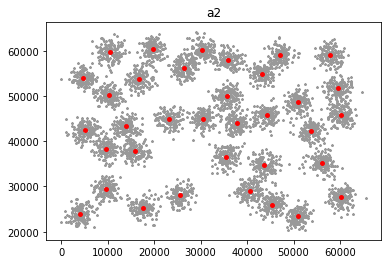

In [3]:
dataMat = pd.read_csv('./Raw_data/all/'+data, header=None, dtype=np.float64).values
print(dataMat.shape)
plt.scatter(dataMat[:, 0],dataMat[:, 1], s=5, c='0.6', marker='*')

gt = pd.read_csv('./Groundtruth/all/'+data, dtype=np.float64).values
print(gt.shape,type(gt))
#plot(gt[:, 0],gt[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plt.scatter(gt[:, 0],gt[:, 1], s=15, c='r', marker='o')
plt.title(data.strip(".csv"))

In [22]:
def over_param(X, k, seed, init_k, init_method ='random', maxIter=30):
    kms = KMeans(n_clusters=init_k, init=init_method,n_init=1,random_state=seed,algorithm='full').fit(X)
    betas = kms.cluster_centers_ 
    labels = kms.labels_
    sse = [kms.inertia_]
    store_C = [betas]  
    while len(betas) != k:
        MFO_index = detect_mfo_distance(X, labels, betas)
        betas = fussion(betas, MFO_index)

        kms = KMeans(n_clusters=len(betas), init=betas,algorithm='full').fit(X)
        betas = kms.cluster_centers_
        labels = kms.labels_
        sse.append(kms.inertia_)
        store_C.append(betas)
    return store_C, sse

In [23]:
'''
init_k = '2k'
init_k = '3k'
init_k = '4k'
init_method = 'random'
init_method = 'k-means++'
'''
def expriment(data, trials, data_gt=None, init_k='2k', init_method='random', maxIter=30):
    if data_gt==None:
        data_gt = data
    ####raw_data####
    X = pd.read_csv('./Raw_data/all/'+data, header=None, dtype=np.float64).values 
    ####ground truth####
    gt = pd.read_csv('./Groundtruth/all/'+data_gt, dtype=np.float64).values
    ##################
    ####setting####
    ##################
    k = len(gt)
    SSE_list = []
    CI_list = []
    Iters = []
    Success_rate = 0 
    ##################
    ####Groud truth SSE
    ##################
    gt_model = KMeans(n_clusters=k, init=gt, random_state = 0, n_init=1, algorithm='full').fit(X)
    gt_sse = gt_model.inertia_
    ##################          
    #Main Loop
    ################## 
    start_time=time.time()
    next_seed = 0
    for i in range(trials):
        if init_k == '2k':
            i_k = 2*k
            store_C,SSE = over_param(X, k, i, init_k=i_k) 
        elif init_k == '3k':
            i_k = 3*k
            store_C,SSE = over_param(X, k, i, init_k=i_k) 
        elif init_k == '4k':
            i_k = 4*k
            store_C,SSE = over_param(X, k, i, init_k=i_k)            
        ##################          
        #Centroid Index
        ################## 
        CI = Centroid_Index(gt,store_C[-1])
        CI_list.append(CI)
        SSE_list.append(SSE[-1])
        if CI == 0:
            Success_rate+=1 
        Iters.append(len(store_C))
    Success_rate = Success_rate/trials * 100
    AMR = np.mean(CI_list)/k
    SSE_ratio = np.array(SSE_list)/gt_sse
    SSE_ratio_mean = np.mean(SSE_ratio)
    SSE_ratio_std = np.std(SSE_ratio)
    Iters_mean = np.mean(Iters)
    elapse_time = time.time()-start_time
    
    return (Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std, Iters_mean, i_k, elapse_time)

In [26]:
experiment_record = {}
datasets = ['a1.csv', 'a2.csv', 'a3.csv',
           's1.csv', 's2.csv', 's3.csv','s4.csv',
           'unbalance.csv', 'dim032.csv']#'birch1.csv']
           #['a1_vary.csv', 'a2_vary.csv', 'a3_vary.csv', 'a3_vary2.csv' ]
           #['dim032.csv','dim064.csv','dim128.csv','dim256.csv','dim512.csv','dim1024.csv']
           #['a1.csv', 'a2.csv', 'a3.csv']
           #['s1.csv', 's2.csv', 's3.csv','s4.csv']
           #['dim032.csv','dim064.csv','dim128.csv','dim256.csv','dim512.csv','dim1024.csv']
           #['unbalance.csv','birch1.csv' ]
            
#datasets_gt = ['a1.csv', 'a2.csv']
init_K = ['2k','3k','4k']

for index, data in enumerate(datasets):
    print (data)
    for sub_index, init_k in enumerate(init_K):
        Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std, Iters_mean, k, elapse_time = expriment(data, trials=100, 
        data_gt=None, init_k=init_k, init_method='random')
        experiment_record[index*3+sub_index]= {'dataset': data,
                                               'method': init_k,
                                               'success_rate': Success_rate,
                                               'AMR': AMR,
                                               'SSE_ratio_mean': SSE_ratio_mean,
                                               'SSE_ratio_std': SSE_ratio_std,
                                               'Iters': Iters_mean,
                                               'Init_k': k,
                                               'Time': elapse_time}

pd.DataFrame.from_dict(experiment_record, orient='index')

a1.csv
a2.csv
a3.csv
s1.csv
s2.csv
s3.csv
s4.csv
unbalance.csv
dim032.csv


,dataset,method,success_rate,AMR,SSE_ratio_mean,SSE_ratio_std,Iters,Init_k,Time
0,a1.csv,2k,96.0,0.002000,1.009463,0.050879,21.0,40,31.598378
1,a1.csv,3k,100.0,0.000000,0.999741,0.000093,41.0,60,72.820621
2,a1.csv,4k,100.0,0.000000,0.999725,0.000027,61.0,80,133.273617
3,a2.csv,2k,88.0,0.003429,1.013799,0.040052,36.0,70,97.557190
4,a2.csv,3k,99.0,0.000286,1.000943,0.009803,71.0,105,284.696163
5,a2.csv,4k,100.0,0.000000,0.999966,0.000025,106.0,140,581.959586
6,a3.csv,2k,89.0,0.002400,1.011296,0.033153,51.0,100,220.470537
7,a3.csv,3k,100.0,0.000000,1.000033,0.000024,101.0,150,654.452679
8,a3.csv,4k,100.0,0.000000,1.000033,0.000022,151.0,200,1317.065758
9,s1.csv,2k,97.0,0.002000,1.017845,0.101485,16.0,30,31.237994


In [27]:
pd.DataFrame.from_dict(experiment_record, orient='index').to_csv('over_param.csv')

In [28]:
experiment_record = {}
datasets = ['birch1.csv']
           #['a1_vary.csv', 'a2_vary.csv', 'a3_vary.csv', 'a3_vary2.csv' ]
           #['dim032.csv','dim064.csv','dim128.csv','dim256.csv','dim512.csv','dim1024.csv']
           #['a1.csv', 'a2.csv', 'a3.csv']
           #['s1.csv', 's2.csv', 's3.csv','s4.csv']
           #['dim032.csv','dim064.csv','dim128.csv','dim256.csv','dim512.csv','dim1024.csv']
           #['unbalance.csv','birch1.csv' ]
            
#datasets_gt = ['a1.csv', 'a2.csv']
init_K = ['2k','3k','4k']

for index, data in enumerate(datasets):
    print (data)
    for sub_index, init_k in enumerate(init_K):
        Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std, Iters_mean, k, elapse_time = expriment(data, trials=100, 
        data_gt=None, init_k=init_k, init_method='random')
        experiment_record[index*3+sub_index]= {'dataset': data,
                                               'method': init_k,
                                               'success_rate': Success_rate,
                                               'AMR': AMR,
                                               'SSE_ratio_mean': SSE_ratio_mean,
                                               'SSE_ratio_std': SSE_ratio_std,
                                               'Iters': Iters_mean,
                                               'Init_k': k,
                                               'Time': elapse_time}

pd.DataFrame.from_dict(experiment_record, orient='index')

birch1.csv


,dataset,method,success_rate,AMR,SSE_ratio_mean,SSE_ratio_std,Iters,Init_k,Time
0,birch1.csv,2k,100.0,0.0,1.000034,0.000040,101.0,200,1527.323255
1,birch1.csv,3k,100.0,0.0,1.000025,0.000036,201.0,300,7254.463377
2,birch1.csv,4k,100.0,0.0,1.000038,0.000035,301.0,400,8469.875417


In [29]:
pd.DataFrame.from_dict(experiment_record, orient='index').to_csv('over_param_birch1.csv')

# Simple test

In [10]:
X = dataMat
init_k = 2*len(gt)
store_C,SSE = over_param(X, 35, 100, init_k)

In [15]:
print(len(store_C[-1]),len(store_C[0]))

35 70


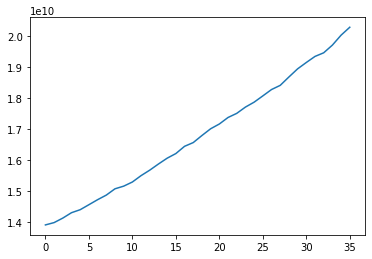

In [13]:
plot(sse)

<Figure size 432x288 with 0 Axes>

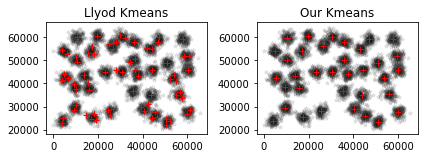

In [14]:
#--------------------------------------------------------------------------------
#------------------------------------Figure--------------------------------------
#--------------------------------------------------------------------------------
figure()
fig = plt.figure()
#Fisrt plot
plt.subplot(121)
ax = plt.subplot(221)
ax.set_title('Llyod Kmeans')
plot(dataMat[:, 0], dataMat[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plot(store_C[0][:, 0],store_C[0][:, 1], 'r+')
'''
i = 0
for a,b in zip(store_C[0][:, 0],store_C[0][:, 1]):
    i += 1
    plt.text(a+2, b+2, '%.0f'% i, color = "G", ha='center', va= 'bottom',fontsize=9)
'''
#Second plot
plt.subplot(122)
ax = plt.subplot(222)
ax.set_title('Our Kmeans')
plot(dataMat[:, 0], dataMat[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plot(store_C[-1][:, 0],store_C[-1][:, 1], 'r+')
'''
i = 0
for a,b in zip(store_C[-1][:, 0],store_C[-1][:, 1]):
    i += 1
    plt.text(a+2, b+2, '%.0f'% i, color = "G", ha='center', va= 'bottom',fontsize=9)
'''
#adjust entire empty space
fig.tight_layout()